In [1]:
%matplotlib inline
import matplotlib.pyplot as plt


In [2]:

import os
import itertools
import numpy as np
import torch
import torch.jit
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import sklearn.decomposition
import sklearn.manifold
import sklearn.neighbors
import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
import polars as pl
import scipy.stats
from mpl_toolkits.axes_grid1 import ImageGrid



## Analyze runs

In [3]:

from pathlib import Path
import glob
import yaml
from LatentEvolution.latent import ModelParams, LatentModel
from typing import Any, Dict, List, MutableMapping, Tuple

In [4]:
expt_code = "add_stimulus_lr"


In [5]:


def flatten_dict(
    d: MutableMapping[str, Any], parent_key: str = "", sep: str = "."
) -> Dict[str, Any]:
    items: List[Tuple[str, Any]] = []
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, MutableMapping):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)



run_dir_base = Path("/groups/saalfeld/home/kumarv4/repos/NeuralGraph/runs") / expt_code
assert run_dir_base.exists()


run_dirs = [Path(p) for p in glob.glob(f"{run_dir_base}/*")]
configs = []
metrics = []
model_params = {}
metric_keys = None
for run_dir in run_dirs:
    with open(run_dir / "config.yaml") as fin:
        raw = yaml.safe_load(fin)
    config = ModelParams.model_validate(raw)
    model_params[run_dir] = config
    raw_flat = flatten_dict(raw)
    configs.append(raw_flat)

    metrics_file = run_dir / "final_metrics.yaml"
    if not metrics_file.exists():
        metrics.append({})
        continue
    with open(metrics_file) as fin:
        raw = yaml.safe_load(fin)
        metrics.append(raw)
        if metric_keys is None:
            metric_keys = sorted(raw.keys())
        else:
            assert metric_keys == sorted(raw.keys())

assert metric_keys is not None, "All runs failed"

config_df = pl.DataFrame(configs)
config_cols = []
for col in config_df.columns:
    if config_df[col].unique().shape[0] > 1:
        config_cols.append(col)
config_cols.sort(key=lambda k: k.count("."))
config_df = config_df.sort(config_cols)

metrics_df = pl.DataFrame(metrics, schema=metric_keys)

df = pl.concat([config_df, metrics_df], how="horizontal").with_columns(
    pl.Series("run_dir", run_dirs)
).sort(config_cols)

In [6]:
df.drop_nulls()[config_cols]

training.batch_size,training.learning_rate,training.seed
i64,f64,i64
256,0.000001,1234
256,0.000001,12345
256,0.00001,1234
256,0.00001,12345
256,0.0001,1234
…,…,…
1024,0.00001,12345
1024,0.0001,1234
1024,0.0001,12345


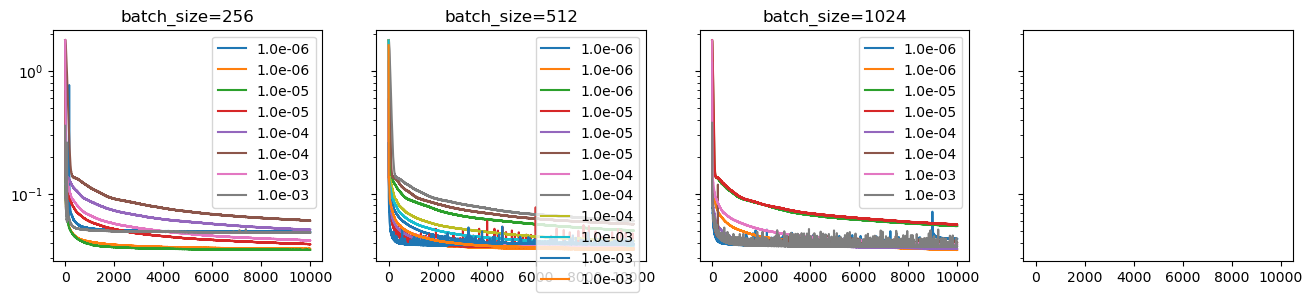

In [7]:
_, ax = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(16, 3))
for i, ((batch_size,), piece) in enumerate(df.drop_nulls().group_by("training.batch_size", maintain_order=True)):
    for row in piece.rows(named=True):
        run_dir = row["run_dir"]
        tdf = pl.read_csv(f"{run_dir}/training_log.csv")
        ax[i].plot(tdf["train_loss"], label=f"{row['training.learning_rate']:.1e}")
    ax[i].set_title(f"{batch_size=}")
    ax[i].legend()
plt.yscale("log")

In [8]:
pick_run_dir = df.filter(pl.col("training.batch_size") == 512).filter(pl.col("training.learning_rate") == 1e-6)["run_dir"][0]
pick_run_dir

PosixPath('/groups/saalfeld/home/kumarv4/repos/NeuralGraph/runs/add_stimulus_lr/20251107_573c815_5949422b')

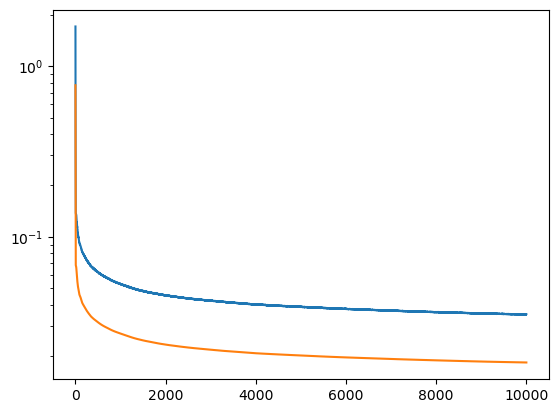

In [15]:
df = pl.read_csv(f"{pick_run_dir}/training_log.csv")
plt.plot(df["train_loss"])
plt.plot(df["val_loss"])
plt.yscale("log")

In [23]:
device=torch.device("cuda")

In [41]:
# load model

model = LatentModel(model_params[pick_run_dir]).to(device)
model.load_state_dict(torch.load(f"{pick_run_dir}/model_final.pt"))
model.eval()
with open(pick_run_dir / "config.yaml") as fin:
    raw = yaml.safe_load(fin)
config = ModelParams.model_validate(raw)

In [17]:
from LatentEvolution.load_flyvis import SimulationResults, FlyVisSim

In [19]:
sim_data = SimulationResults.load("/groups/saalfeld/home/kumarv4/repos/NeuralGraph/graphs_data/fly/fly_N9_62_1/x_list_0.npy")

In [32]:
split = config.training.data_split
val_mat = sim_data[FlyVisSim.VOLTAGE][split.validation_start:split.validation_end]
val_data = torch.tensor(val_mat, device=device)
val_stim = torch.tensor(sim_data[FlyVisSim.STIMULUS][split.validation_start:split.validation_end], device=device)

In [42]:
# reconstruction

proj = model.encoder(val_data)
recon = model.decoder(proj).detach().cpu().numpy()

In [43]:
neuron_types = sim_data[FlyVisSim.TYPE][0]
index_to_name = {0: 'Am', 1: 'C2', 2: 'C3', 3: 'CT1(Lo1)', 4: 'CT1(M10)', 5: 'L1', 6: 'L2',
    7: 'L3', 8: 'L4', 9: 'L5', 10: 'Lawf1', 11: 'Lawf2', 12: 'Mi1', 13: 'Mi10',
    14: 'Mi11', 15: 'Mi12', 16: 'Mi13', 17: 'Mi14', 18: 'Mi15', 19: 'Mi2',
    20: 'Mi3', 21: 'Mi4', 22: 'Mi9', 23: 'R1', 24: 'R2', 25: 'R3', 26: 'R4',
    27: 'R5', 28: 'R6', 29: 'R7', 30: 'R8', 31: 'T1', 32: 'T2', 33: 'T2a',
    34: 'T3', 35: 'T4a', 36: 'T4b', 37: 'T4c', 38: 'T4d', 39: 'T5a', 40: 'T5b',
    41: 'T5c', 42: 'T5d', 43: 'Tm1', 44: 'Tm16', 45: 'Tm2', 46: 'Tm20', 47: 'Tm28',
    48: 'Tm3', 49: 'Tm30', 50: 'Tm4', 51: 'Tm5Y', 52: 'Tm5a', 53: 'Tm5b',
    54: 'Tm5c', 55: 'Tm9', 56: 'TmY10', 57: 'TmY13', 58: 'TmY14', 59: 'TmY15',
    60: 'TmY18', 61: 'TmY3', 62: 'TmY4', 63: 'TmY5a', 64: 'TmY9'
}
neuron_type_name = [
    "Am", "C2", "C3", "CT1(Lo1)", "CT1(M10)",
    "L1", "L2", "L3", "L4", "L5", "Lawf1", "Lawf2",
    "Mi1", "Mi10", "Mi11", "Mi12", "Mi13", "Mi14", "Mi15", "Mi2", "Mi3", "Mi4", "Mi9",
    "R1", "R2", "R3", "R4", "R5", "R6", "R7", "R8",
    "T1", "T2", "T2a", "T3", "T4a", "T4b", "T4c", "T4d", "T5a", "T5b", "T5c", "T5d",
    "Tm1", "Tm16", "Tm2", "Tm20", "Tm28", "Tm3", "Tm30", "Tm4", "Tm5Y",
    "Tm5a", "Tm5b", "Tm5c", "Tm9", "TmY10", "TmY13", "TmY14",
    "TmY15", "TmY18", "TmY3", "TmY4", "TmY5a", "TmY9"
]
neuron_type_index = {t: i for i, t in enumerate(neuron_type_name)}

def compute_ixs_per_type(neuron_types):
    """Compute indices corresponding to each neuron type."""
    order = np.argsort(neuron_types)
    uniq_types, start_index = np.unique(neuron_types[order], return_index=True)
    num_neuron_types = len(uniq_types)
    assert (uniq_types == np.arange(num_neuron_types)).all(), "breaks assumptions"
    breaks = np.zeros(len(uniq_types)+1, dtype=np.int64)
    breaks[:-1] = start_index
    breaks[-1] = len(neuron_types)
    return [
        order[breaks[i]:breaks[i+1]] for i in range(num_neuron_types)
    ]
neuron_ixs_by_type = compute_ixs_per_type(neuron_types)


In [68]:
# val_stim.shape, val_data.shape
evolved = model(val_data, val_stim[:, :1736]).detach().cpu()

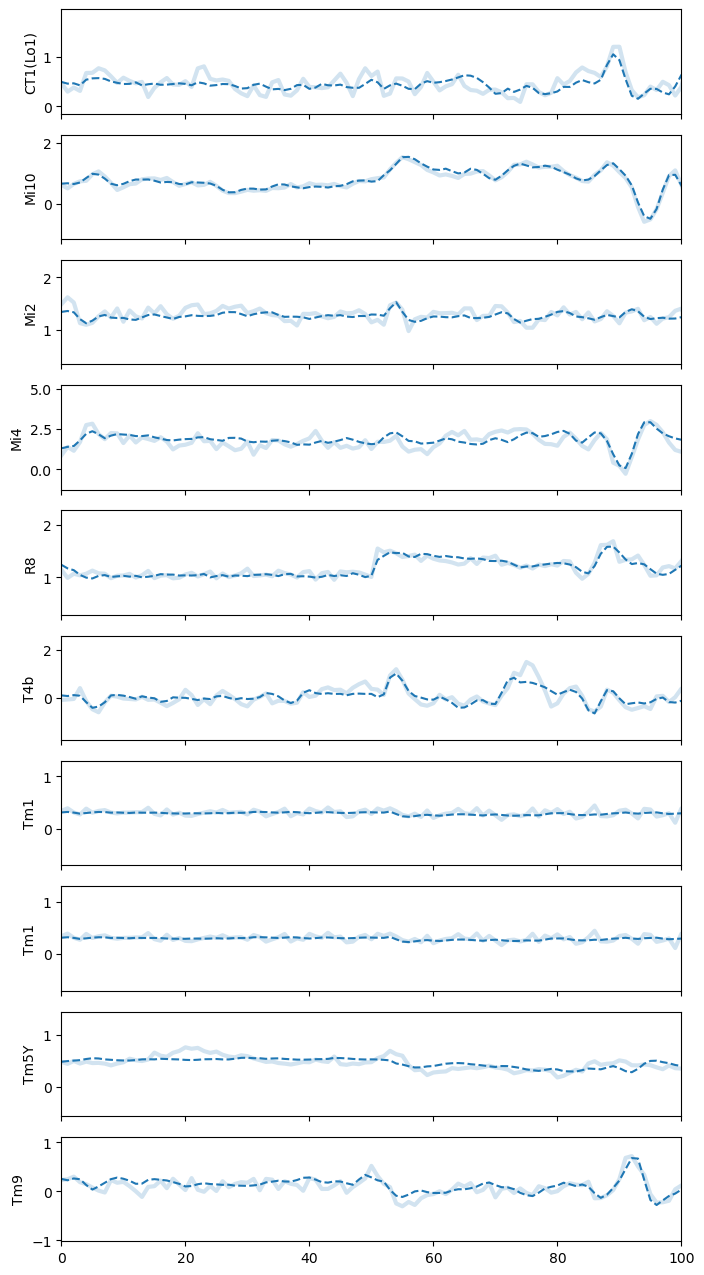

In [123]:

plot_neuron_types = np.sort(np.random.choice(neuron_type_name, 10))
# plot_neuron_types = ['R1', 'R7', 'C2', 'Mi11', 'Tm1', 'Tm4', 'Tm30']

_, ax = plt.subplots(len(plot_neuron_types), 1, figsize=(8, 16), sharex=True)
t0 = 0
T = val_mat.shape[0]
tvals = np.arange(t0, t0 + T)
rng = np.random.default_rng(seed=123)
picks = [rng.choice(nixs) for nixs in neuron_ixs_by_type]

for i, ptype in enumerate(plot_neuron_types):
    nix = picks[neuron_type_index[ptype]]
    true_trace = val_mat[:, nix]
    p = ax[i].plot(
        tvals,
        recon[:, nix],
        ls="dashed",
        # marker=".",
        label="reconstruct each time point",
    )

    ax[i].plot(tvals, true_trace, lw=3, color=p[-1].get_color(), alpha=0.2)
    ylim = ax[i].get_ylim()
    yc = 0.5*(ylim[0] + ylim[1])
    ylen = ylim[1] - ylim[0]
    if ylen < 2:
        ylim = (yc-1, yc+1)


    # # ax[i].set_ylim(1, 2)
    # # # time evolve
    # ax[i].plot(
    #     tvals,
    #     evolved[:, nix],
    #     color=p[-1].get_color(),
    #     ls="dotted",
    #     label="learn linear evolver",
    # )


    ax[i].set_ylim(*ylim)
    ax[i].set_ylabel(ptype)
plt.xlim(0, 100)
plt.subplots_adjust(hspace=0.2)

In [72]:
delta_val = np.diff(val_mat, axis=0)
pred_delta = evolved[:-1] - val_mat[:-1]

/tmp/ipykernel_274/1855755518.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  pred_delta = evolved[:-1] - val_mat[:-1]


In [84]:
vmin, vmax = delta_val.min(), delta_val.max()

In [104]:
nbins=50
bins = np.linspace(np.floor(vmin), np.ceil(vmax), nbins+1)
mps = 0.5*(bins[1:] + bins[:-1])
ixs = np.searchsorted(bins, delta_val)


In [111]:

den = np.bincount(ixs.ravel(), minlength=nbins+1)
num = np.bincount(ixs.ravel(), weights=pred_delta.ravel(), minlength=nbins+1)
num2 = np.bincount(ixs.ravel(), weights=np.power(pred_delta.ravel(), 2), minlength=nbins+1)
mean = num/den
err2 = num2/den - num**2 / den**2

/tmp/ipykernel_274/1552955647.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  num2 = np.bincount(ixs.ravel(), weights=np.power(pred_delta.ravel(), 2), minlength=nbins+1)
/tmp/ipykernel_274/1552955647.py:4: RuntimeWarning: invalid value encountered in divide
  mean = num/den
/tmp/ipykernel_274/1552955647.py:5: RuntimeWarning: invalid value encountered in divide
  err2 = num2/den - num**2 / den**2


In [112]:
sigma = np.sqrt(err2)

/tmp/ipykernel_274/3266153455.py:1: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(err2)


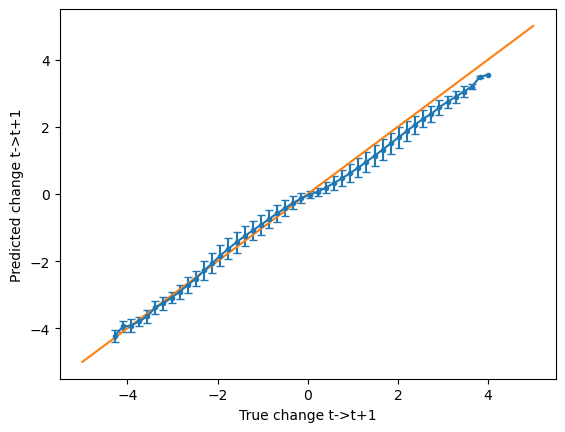

In [114]:
plt.errorbar(bins, mean, yerr=sigma, marker=".", capsize=3)
plt.xlabel("True change t->t+1")
plt.ylabel("Predicted change t->t+1")
plt.plot([-5, 5], [-5, 5])

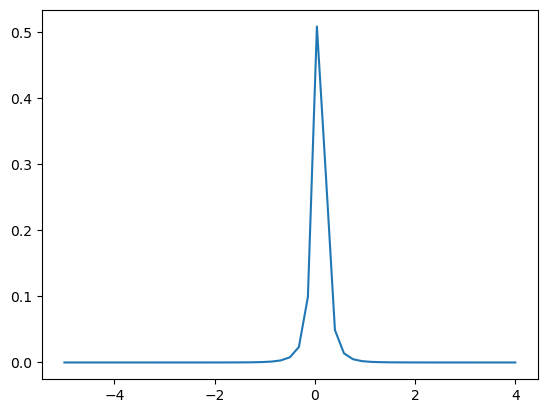

In [119]:
plt.plot(bins, den / den.sum())

## Old stuff

In [140]:
device = torch.device("cuda")

train_tensor = torch.concatenate(
    [
        torch.tensor(train_mat, device=device),
        torch.tensor(stimulus[train_start:train_end], device=device),
    ],
    dim=1,
)
train_tensor.shape

torch.Size([17744, 15477])

In [141]:
# use tf32 math for speed - but perhaps we are sacrificing accuracy in roll out
torch.set_float32_matmul_precision('high')

In [147]:
class MLP(torch.nn.Module):
    def __init__(
        self,
        num_input_dims: int,
        num_output_dims: int,
        num_hidden_layers: int,
        num_hidden_units: int,
    ):
        super().__init__()
        self.layers = torch.nn.ModuleList()
        input_dims = num_input_dims
        for i in range(num_hidden_layers):
            linear = torch.nn.Linear(input_dims, num_hidden_units)
            torch.nn.init.normal_(linear.weight, mean=0.0, std=0.01)
            torch.nn.init.zeros_(linear.bias)
            self.layers.append(linear)
            self.layers.append(torch.nn.Tanh())
            input_dims = num_hidden_units
        self.layers.append(torch.nn.Linear(num_hidden_units, num_output_dims))

    def forward(self, x):
        y = self.layers[0](x)
        for layer in self.layers[1:-1]:
            y = layer(y)
        return self.layers[-1](y)

class MLPWithResidual(torch.nn.Module):
    def __init__(
        self,
        num_input_dims: int,
        num_output_dims: int,
        num_hidden_layers: int,
        num_hidden_units: int,
    ):
        super().__init__()
        self.layers = torch.nn.ModuleList()
        input_dims = num_input_dims
        for i in range(num_hidden_layers):
            linear = torch.nn.Linear(input_dims, num_hidden_units)
            torch.nn.init.normal_(linear.weight, mean=0.0, std=0.01)
            torch.nn.init.zeros_(linear.bias)
            self.layers.append(linear)
            self.layers.append(torch.nn.Tanh())
            input_dims = num_hidden_units
        self.layers.append(torch.nn.Linear(num_hidden_units, num_output_dims))

    def forward(self, x):
        y = self.layers[0](x)
        for layer in self.layers[1:-1]:
            y = y + layer(y)
        return self.layers[-1](y)



class MLPWithLinear(torch.nn.Module):
    def __init__(
        self,
        num_input_dims: int,
        num_output_dims: int,
        num_hidden_layers: int,
        num_hidden_units: int,
    ):
        super().__init__()
        self.layers = torch.nn.ModuleList()
        input_dims = num_input_dims
        for i in range(num_hidden_layers):
            linear = torch.nn.Linear(input_dims, num_hidden_units)
            self.layers.append(linear)
            self.layers.append(torch.nn.Tanh())
            input_dims = num_hidden_units
        self.layers.append(torch.nn.Linear(num_hidden_units, num_output_dims))
        for layer in self.layers:
            if isinstance(layer, torch.nn.Linear):
                torch.nn.init.normal_(layer.weight, mean=0.0, std=0.01)
                torch.nn.init.zeros_(layer.bias)
        self.linear_layer = torch.nn.Linear(num_input_dims, num_output_dims)

    def forward(self, x):
        y = self.layers[0](x)
        for layer in self.layers[1:-1]:
            y = layer(y)

        return self.layers[-1](y) + self.linear_layer(x)


class Encoder(torch.nn.Module):
    def __init__(self, **mlp_kwargs):
        super().__init__()
        self.mlp = MLPWithResidual(**mlp_kwargs)
        # self.linear = torch.nn.Linear(mlp_kwargs["num_input_dims"], mlp_kwargs["num_output_dims"])


    def forward(self, x):
        return self.mlp(x) #+ self.linear(x)


class Evolver(torch.nn.Module):
    def __init__(self, time_units: int, **mlp_kwargs):
        super().__init__()
        self.time_units = time_units
        self.evolver = MLPWithResidual(**mlp_kwargs)

    def forward(self, x):
        for _ in range(self.time_units):
            x = x + self.evolver(x)
        return x


class Decoder(torch.nn.Module):
    def __init__(self, **mlp_kwargs):
        super().__init__()
        self.mlp = MLPWithResidual(**mlp_kwargs)
        # self.linear = torch.nn.Linear(mlp_kwargs["num_input_dims"], mlp_kwargs["num_output_dims"])


    def forward(self, x):
        return self.mlp(x) #+ self.linear(x)

In [288]:

L = 512
# MAX_VALUE = 2.0
encoder = Encoder(
    # max_value=MAX_VALUE,
    num_input_dims=train_tensor.shape[1],
    num_output_dims=L,
    num_hidden_layers=3,
    num_hidden_units=L,
).cuda()

decoder = Decoder(
    # max_value=MAX_VALUE,
    num_input_dims=L,
    num_output_dims=train_mat.shape[1],
    num_hidden_layers=3,
    num_hidden_units=L,
).cuda()
evolver = Evolver(
    time_units=OBS_TIME_STEPS,
    # max_value=MAX_VALUE,
    num_input_dims=L,
    num_output_dims=L,
    num_hidden_layers=3,
    num_hidden_units=L,
).cuda()


# train_with_evolution_opt = torch.compile(train_with_evolution, fullgraph=True, mode="reduce-overhead")


In [316]:

a = [1]
a[1:-1]

[]

In [289]:

@torch.compile(fullgraph=True, mode="reduce-overhead")
def train_with_evolution(encoder, decoder, evolver, train_tensor, rollout=1):

    proj = encoder(train_tensor)
    recon = decoder(proj)

    # remove stimulus piece at the end
    activity = train_tensor[:, :-1736]

    # reconstruction loss
    recon_loss = torch.nn.MSELoss()(activity, recon)

    for _ in range(rollout):
        proj = evolver(proj)
    recon1 = decoder(proj)
    # time steps are nearby
    evolve_loss = torch.nn.MSELoss()(recon1[:-rollout], activity[rollout:])
    # evolve_loss = torch.tensor(0.0)

    # proj = evolver(proj)
    # recon2 = decoder(proj)
    # # time steps are nearby
    # evolve_loss += torch.nn.MSELoss()(recon2[:-2], activity[2:])

    return evolve_loss, recon_loss

In [290]:

# # First train encoder/decoder
# opt = torch.optim.Adam(
#     list(itertools.chain(encoder.parameters(), decoder.parameters(), evolver.parameters())),
#     lr=1e-3,
# )
# loop = tqdm.trange(10000, ncols=120)
# for i in loop:
#     opt.zero_grad(True)

#     loss = train_encoded_rep(encoder, decoder, evolver, train_tensor)
#     loop.set_postfix(
#         # recon=recon_loss.item(),
#         recon_loss=loss.item(),
#         # lr=f"{scheduler1.get_last_lr()[0]:.3e}"
#     )
#     loss.backward()
#     opt.step()

# now train with the evolver
# First train encoder/decoder
opt = torch.optim.Adam(
    list(itertools.chain(encoder.parameters(), decoder.parameters(), evolver.parameters())),
    lr=1e-4,
)
# scheduler1 = torch.optim.lr_scheduler.MultiStepLR(
#     opt, milestones=[10000,], gamma=0.1,
# )
# scheduler2 = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
#     opt, T_0=100, T_mult=2, eta_min=1e-6
# )
# scheduler = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[1000, 10_000], gamma=0.1)
loop = tqdm.trange(100_000, ncols=120)
for i in loop:
    opt.zero_grad()

    evolve_loss, recon_loss = train_with_evolution(encoder, decoder, evolver, train_tensor)
    loss = evolve_loss + recon_loss
    loop.set_postfix(
        recon=recon_loss.item(),
        evolve_loss=evolve_loss.item(),
        # lr=f"{scheduler1.get_last_lr()[0]:.3e}"
    )

    loss.backward()
    opt.step()
    # scheduler1.step()
    # scheduler2.step()

100%|██████████████████████████████████████| 100000/100000 [2:23:52<00:00, 11.58it/s, evolve_loss=0.0032, recon=0.00304]


In [308]:
train_tensor.shape

torch.Size([17744, 15477])

In [291]:
# opt = torch.optim.Adam(
#     list(itertools.chain(encoder.parameters(), decoder.parameters(), evolver.parameters())),
#     lr=1e-4,
# )
# loop = tqdm.trange(10000, ncols=120)
# for i in loop:
#     opt.zero_grad(True)

#     loss, recon_loss = train_with_evolution(encoder, decoder, evolver, train_tensor)
#     loop.set_postfix(
#         recon=recon_loss.item(),
#         loss=loss.item(),
#         # lr=f"{scheduler1.get_last_lr()[0]:.3e}"
#     )

#     loss.backward()
#     opt.step()

In [292]:
# Save models
# ep = torch.export.export(encoder, (train_tensor,))
# torch.export.save(ep, "/mnt/localdata/encoder.pt2")
# proj = encoder(train_tensor)
# ep = torch.export.export(decoder, (proj,))
# torch.export.save(ep, "/mnt/localdata/decoder.pt2")
# ep = torch.export.export(evolver, (proj,))
# torch.export.save(ep, "/mnt/localdata/evolver.pt2")

In [293]:
val_tensor = torch.concatenate(
    [
        torch.tensor(val_mat, device=device),
        torch.tensor(stimulus[validation_start:validation_end], device=device),
    ],
    dim=1,
)

In [294]:
proj = encoder(val_tensor)
recon = decoder(proj)

proj1 = proj.detach().cpu().numpy()
recon1 = recon.detach().cpu().numpy()

In [295]:
with torch.no_grad():
    x0 = encoder(val_tensor[:1, :])
    results = [x0]
    for _ in range((val_tensor.shape[0] - 1)):
        prev = results[-1]
        state = prev.detach().clone()
        state = evolver(state)
        results.append(state)
    final = decoder(torch.cat(results, dim=0))
    final1 = final.detach().cpu().numpy()

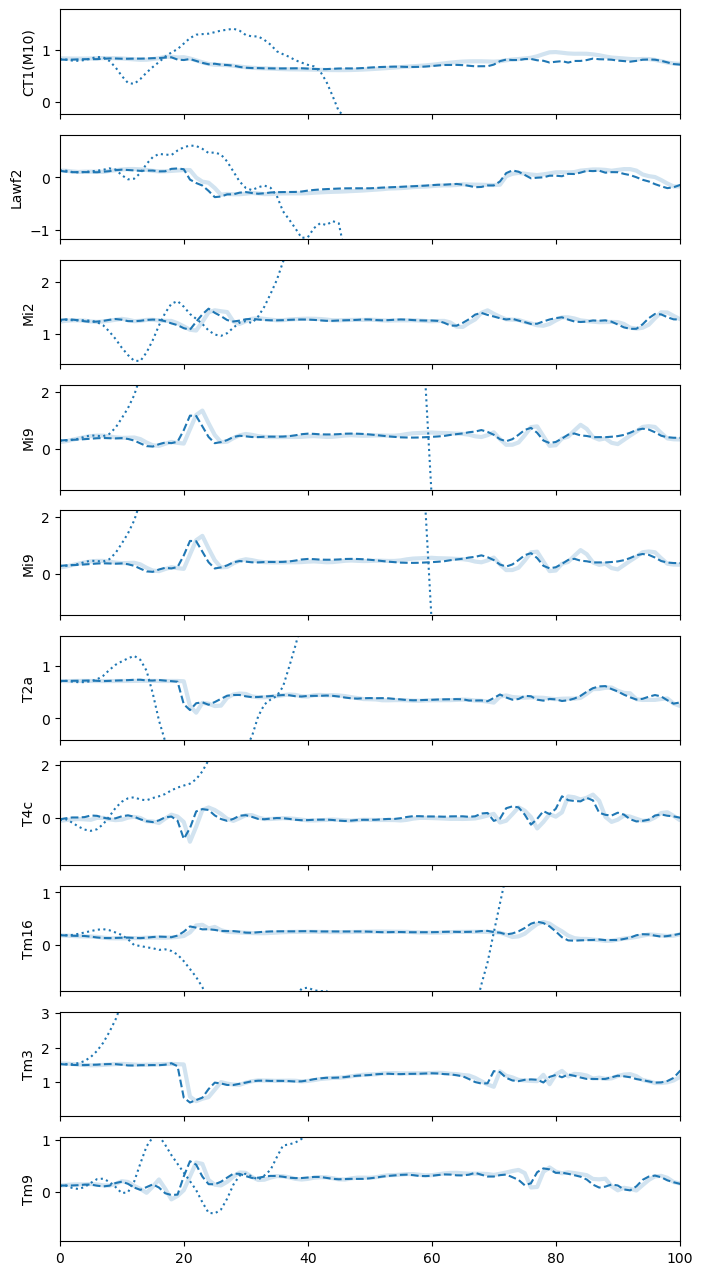

In [307]:

plot_neuron_types = np.sort(np.random.choice(neuron_type_name, 10))
# ['R1', 'R7', 'C2', 'Mi11', 'Tm1', 'Tm4', 'Tm30']

_, ax = plt.subplots(len(plot_neuron_types), 1, figsize=(8, 16), sharex=True)
t0 = 0
T = val_mat.shape[0]
tvals = np.arange(t0, t0 + T)
rng = np.random.default_rng(seed=123)
picks = [rng.choice(nixs) for nixs in neuron_ixs_by_type]

for i, ptype in enumerate(plot_neuron_types):
    nix = picks[neuron_type_index[ptype]]
    true_trace = val_mat[:, nix]
    p = ax[i].plot(
        tvals,
        recon1[:, nix],
        ls="dashed",
        # marker=".",
        label="reconstruct each time point",
    )

    ax[i].plot(tvals, true_trace, lw=3, color=p[-1].get_color(), alpha=0.2)
    ylim = ax[i].get_ylim()
    yc = 0.5*(ylim[0] + ylim[1])
    ylen = ylim[1] - ylim[0]
    if ylen < 2:
        ylim = (yc-1, yc+1)


    # ax[i].set_ylim(1, 2)
    # time evolve
    ax[i].plot(
        tvals,
        final1[:, nix],
        color=p[-1].get_color(),
        ls="dotted",
        label="learn linear evolver",
    )


    ax[i].set_ylim(*ylim)
    ax[i].set_ylabel(ptype)
plt.xlim(0, 100)
plt.subplots_adjust(hspace=0.2)

In [297]:
delta = (val_mat - final1).astype(np.float64)
val_mat_shuffle = val_mat.copy()
rng = np.random.default_rng(seed=0)
rng.shuffle(val_mat_shuffle, axis=0)
delta_shuffle = val_mat_shuffle - val_mat

delta_constant = val_mat - val_mat[:1]

Text(0.5, 0, 'Time')

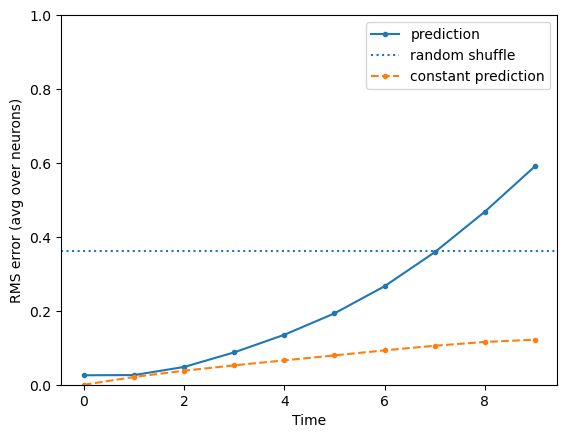

In [298]:
rms_shuffle = np.sqrt(np.power(delta_shuffle, 2).mean(axis=1))
rms_pred =np.sqrt(np.power(delta, 2).mean(axis=1))
rms_constant =np.sqrt(np.power(delta_constant, 2).mean(axis=1))
plt.plot(rms_pred[:10], marker=".", label="prediction")

plt.axhline(rms_shuffle.mean(), ls="dotted", label="random shuffle")
plt.plot(rms_constant[:10], ls="dashed", marker=".", label="constant prediction")
# plt.yscale("log")
plt.ylim(0, 1)
plt.legend()
plt.ylabel("RMS error (avg over neurons)")
plt.xlabel("Time")

In [299]:
proj1 = evolver(proj)
recon1 = decoder(proj1).detach().cpu().numpy()
dx_true = val_mat[1:] - val_mat[:-1]
dx_pred = recon1[:-1] - val_mat[:-1]
err = dx_pred - dx_true

In [300]:
# npts = 500
# rng = np.random.default_rng(seed=0)
# t0s = np.sort(rng.choice(val_tensor.shape[0], replace=False, size=npts))
# x0 = val_mat[t0s, :]
# proj_x0 = proj[t0s, :]
# x1_pred = decoder(evolver(proj_x0)).detach().cpu().numpy()
# x1_true = val_mat[t0s+1, :]

In [301]:
# dx_pred = x1_pred - x0
# dx_true = x1_true - x0


In [302]:
bins = np.linspace(-0.5, 0.5, 101)
mps = 0.5*(bins[1:] + bins[:-1])
den, _ = np.histogram(dx_true, bins=bins)
num, _ = np.histogram(dx_true, bins=bins, weights=np.abs(err))

Text(0.5, 0, 'v(t+1) - v(t) true')

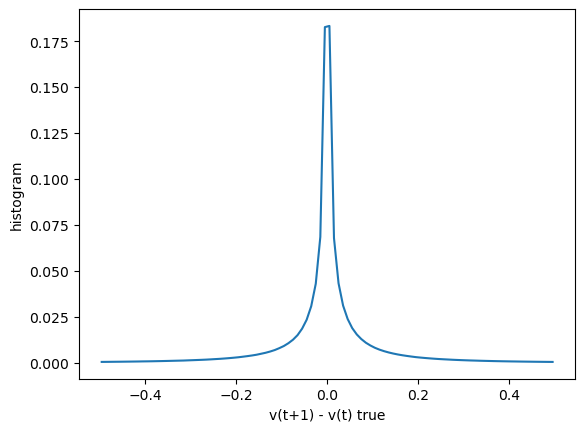

In [303]:
plt.plot(mps, den / den.sum())
plt.ylabel("histogram")
plt.xlabel("v(t+1) - v(t) true")


Text(0, 0.5, 'mean absolute error in prediction')

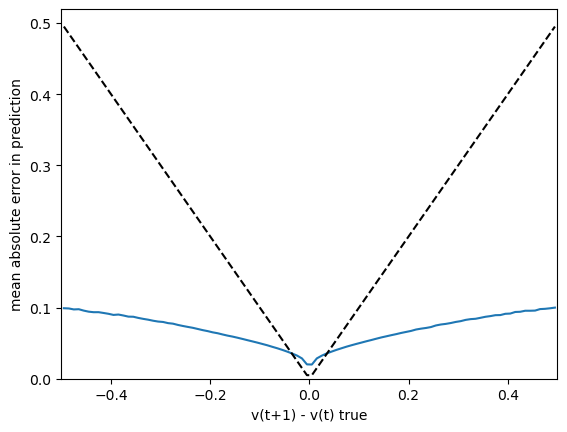

In [304]:

plt.plot(mps, num / den)
plt.plot(mps, np.abs(mps), color="k", ls="dashed")
plt.xlabel("v(t+1) - v(t) true")
plt.xlim(-0.5, 0.5)
plt.ylim(0, None)
plt.ylabel("mean absolute error in prediction")
